# African Airlines Sentiment Analysis (2015-Present)
**Modeling & (Aspect Based) Sentiment Analysis V1**

**Goal:** Conduct a basic aspect-based sentiment analysis on airlines with the [aspect-based-sentiment-analysis (ABSA) package](https://github.com/ScalaConsultants/Aspect-Based-Sentiment-Analysis)

The (airline) aspects in focus are:
- Seat
- Cabin staff service
- Food
- Inflight entertainment
- Ground service
- WiFi

---

**Skip to the code if you are not interested in a brief discussion of the eventual ABSA process. This can also easily be inferred from the code**

---

#### ABSA process
To conduct the ABSA, aspect classes (enumerated above) are manually indicated as well as terms that are likely linked to these e.g. food: meal, food.


These aspect terms are then searched for in the review text and if they exist, the sentiment (positive, negative, or neutral) of the word is inferred from the context of the sentence.


#### Model Evaluation
To evaluate the efficacy/accuracy of the ABSA, we utilized one of the preprocessed datasets. In this dataset, the airline aspects (enumerated above) ratings (from 1-5) were mapped to categorical sentiment groups thus:

$$ 1-2: Negative \ \ | \ \ \ 3: Neutral \ \ \ | \ \ \  4-5: Positive$$


Subsequently, aspect predictions where the model found no aspect term were replaced with NaNs. For example, if the mapping of ratings to sentiment groups in a particular review reported food as being 'Positive' and the model did not find food to be discussed in this same review, then the sentiment ('Positive') for that review is replaced with a NaN. This is done so that the model's predictions are all that are evaluated and not cases where the model does not predict. There are a few reasons/assumptions behind this action:

1. Users reviews do not always cover what they rated as these are two different sections on the review website (i.e. the review is not necessarily exhaustive). Hence, there is no way for the model to deduce what the reviewer thought of an aspect if it was not actually expressed in the review (hence why the rated sentiment is replaced with a NaN since that sentiment was not expressed in the review)
2. In some sense, we are putting too much faith in the model. It is possible that the reviewer did express sentiment on the aspect but the model did not catch this. In this case, we still go with the model and believe that the service aspect (e.g. food, cabin crew, etc.) was not discussed in the review text. *This point is especially important since the aspect terms were specified manually and certain terms could definitely have been missed out*.

In [26]:
import scipy.stats as sts

In [33]:
import scipy.stats as sts

In [38]:
!pip uninstall scipy

Found existing installation: scipy 1.7.1
Uninstalling scipy-1.7.1:
  Would remove:
    /Users/koredeakande/opt/anaconda3/lib/python3.7/site-packages/scipy-1.7.1.dist-info/*
    /Users/koredeakande/opt/anaconda3/lib/python3.7/site-packages/scipy/*
  Would not remove (might be manually added):
    /Users/koredeakande/opt/anaconda3/lib/python3.7/site-packages/scipy/.DS_Store
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [39]:
Y

NameError: name 'Y' is not defined

### 1. Library Importation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import aspect_based_sentiment_analysis as absa

### 2. Loading the data

In [3]:
#Dataframe with review text cleaned and encoded sentiment values
airlines_df = pd.read_csv('../data/processed/airlines_processed.csv',index_col=0)

#Convert encoded rating sentiment values to int
airlines_df.iloc[:,6:13] = airlines_df.iloc[:,6:13]

In [4]:
airlines_df.head(3)

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,ive flown ethiopian airlines couple times gene...,Business,Economy Class,August 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0
1,ethiopian-airlines,2021-01-06 00:08:00,fantastic journey flew q turbo prop khartoum a...,Solo Leisure,Economy Class,July 2021,Positive,Positive,Positive,Positive,Positive,NaN,Positive,1
2,ethiopian-airlines,2021-01-29 00:07:00,children stuck transit ethiopia ethiopian airl...,Family Leisure,Economy Class,July 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0


### 3. Quick ABSA

In [5]:
#Load the basic configuration of the ABSA package
nlp = absa.load()

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [6]:
#Note down the possible aspect classes – and their relevant (aspect) terms
aspect_classes = {'seat':['seat'], 
                  'cabin_staff_service': ['crew', 'service', 'staff', 'attendant'], 
                  'food': ['food','meal','breakfast','lunch','dinner'],
                  'inflight_entertainment': ['entertainment','ife','movies','shows', 'music', 'films'], 
                  'ground_service': ['ground service', 'ground  staff'], 'wifi': ['wifi', 'internet']}

In [7]:
def reviews_absa(df,sample_num = None):
    
    """
    Function to run ABSA on a random sample from a review text dataframe. 
    
    To run ABSA specifically, aspect classes and their relevant terms are specified above and aspect terms
    are searched for in the preprocessed review texts. If they exist, the ABSA is carried out by
    looking at the aspect terms in the context of the review text
    
    Inputs:
        - df (pandas Dataframe): Dataframe of reviews
        - sample_num (int): The number of reviews to randomly select from the dataframe
        
    Outputs:
        - rand_idx (list): A list containing the randomly selected indices from the dataframe
        - sentiment_df (pd Dataframe): Dataframe containing the predicted aspect sentiments for the revies
        - review_sentiment_sample (pd Dataframe): Dataframe containing the actual user-reported sentiments
    
    """
    
    #Dataframe to store the eventual sentiment for different aspects
    sentiment_df = pd.DataFrame()
    
    #Generate random number which will serve as selections for review texts
    #Running on all the reviews takes a long time
    rand_idx = np.random.randint(0,len(df),sample_num)

    #Iterate through all the aspects (e.g. seat, ground staff service, etc.)
    for aspect_class in aspect_classes.keys():

        #print('aspect class', aspect_class,'\n')

        #List to store the aspect sentiment for each review for a given aspect
        review_aspect_sentiment = []

        #Iterate through all the reviews
        for review in df.review_text.iloc[rand_idx]:

            #print('review:',review,'\n')

            #List to store the avg sentiment for all relevant aspect terms
            term_sentiments = []

            #Iterate through all the aspect terms for an aspect
            for aspect_term in aspect_classes[aspect_class]:

                #print('aspect_term:',aspect_term,'\n')

                #If the term is in the review
                if aspect_term in review:

                    try:
                        #Try to calculate the sentiment for the aspect term
                        sent = nlp(review,aspects = [aspect_term])

                        #Append the sentiment score to the sentiment scores list
                        term_sentiments.append(np.array(sent.subtasks[aspect_term].examples[0].scores))

                    except:
                        
                        #If any error or exception arises, just pass
                        pass


                #If the term is not in the review, pass
                else:
                    pass

            #If there were multiple aspect terms, find the average sentiment values across all terms
            #Note: This is reported in the form [neutral,negative,positive]
            if len(term_sentiments) > 1:

                avg_sentiments = np.array(term_sentiments).mean(axis=0)

            #If just one, no need to find the average
            elif len(term_sentiments) == 1:

                avg_sentiments = np.array(term_sentiments)

            #If len == 0, no review with the aspect terms was found
            else:
                avg_sentiments = None

            #If avg_sentiment is None, append np.nan indicating no sentiment for the aspect
            if avg_sentiments is None:

                review_aspect_sentiment.append(np.nan)
            
            #If a sentiment score was determined,
            else:

                #Get the sentiment category (neutral,negative,positive) with the largest probability
                max_idx = np.argmax(avg_sentiments)

                if max_idx == 2:

                    review_aspect_sentiment.append("Positive")

                elif max_idx == 1:

                    review_aspect_sentiment.append("Negative")

                else:

                    review_aspect_sentiment.append("Neutral")


            #print(review_aspect_sentiment, '\n\n')

        sentiment_df[aspect_class] = review_aspect_sentiment
    
    #Return the following:
        #1. The indices of the randomly selected reviews
        #2. The data frame containing the sentiment predictions from the absa model
        #3. The true dataframe with the user reported ratings converted to sentiment values
    return rand_idx, sentiment_df, df.iloc[rand_idx,6:12]


In [8]:
def replace_nan_with_str(df,true_df):
    
    """
    Function to replace NaNs with string NaNs to allow for comparison of the values
    """

    #Iterate through all the values in the sentiment dataframe
    for row in range(len(df)):

        for col in range(len(df.columns)):

            #If there was no sentiment prediction from the model (i.e. if np.nan)
            if df.iloc[row,col] not in ['Positive','Negative','Neutral']:

                #Replace the nan prediction with a string (since np.nans cannot be compared with each other)
                df.iloc[row,col] = str(df.iloc[row,col])

                #Replace the review sentiment with a string nan - allowing us compare all available predictions 
                #to actual reported values
                true_df.iloc[row,col] = str(np.nan)
              
    
    return df,true_df

In [9]:
def absa_evaluation(true_df,num_reviews):
    
    """
    Main function to run the aspect-based sentiment analysis. The function does the following:
    1. Calls reviews_absa function predict aspect sentiment on a randomly selected sample of reviews
    2. Calls replace_nan_with_str function to change np.nan values to strings (allowing for easy comparison)
       Note: True review sentiments were the model did not predict anything (i.e. NaN) are also converted to
             string nans. This is so that we only consider the accuracy of the model's predictions
    3. Computes accuracy score for model predictions
    """
    
    #Run aspect based sentiment analysis on num_reviews randomly selected reviews
    _ , sentiment_df, reviews_ratings = reviews_absa(true_df,num_reviews)
    
    #Reprocess in preparation for prediction comparison
    #Here we reformat so only aspects that the model detected and predicted are evaluated
    sentiment_df, reviews_ratings = replace_nan_with_str(sentiment_df, reviews_ratings)
    
    #Calculate the number of predictions
    num_preds = np.array([1 for pred in sentiment_df.values.flatten() if pred != 'nan']).sum()
    
    #Compare predictions to user reported sentiment values 
    comparison_vals = (sentiment_df.values == reviews_ratings.values).flatten()

    #Compute and return the number of predictions and the accuracy
    return num_preds, (comparison_vals.sum()/len(comparison_vals))
    

In [46]:
#List to store accuracy values
accuracy_values = []

#Counter to track total number of (effective) model predictions
num_predictions = 0

#Repeat absa evaluation for 5 runs 
for _ in range(5):
    
    num_pred, accuracy = absa_evaluation(airlines_df,50)
    
    num_predictions += num_pred
    
    accuracy_values.append(accuracy)
    
print(f"Total number of predictions: {num_predictions}")
print(f"Average accuracy: {np.array(accuracy_values).mean()}")


Total number of predictions: 532
Average accuracy: 0.8626666666666667


In [10]:
def absa_dataset(true_df,num_reviews):
    
    #Run aspect based sentiment analysis on num_reviews randomly selected reviews
    _ , sentiment_df, reviews_ratings = reviews_absa(true_df,num_reviews)
    
    #Reprocess in preparation for prediction comparison
    #Here we reformat so only aspects that the model detected and predicted are evaluated
    sentiment_df, reviews_ratings = replace_nan_with_str(sentiment_df, reviews_ratings)
    
    return sentiment_df, reviews_rating


def compute_accuracy(sentiment_df, num_reviews):
    
    #Calculate the number of predictions
    num_preds = np.array([1 for pred in sentiment_df.values.flatten() if pred != 'nan']).sum()
    
    #Compare predictions to user reported sentiment values 
    comparison_vals = (sentiment_df.values == reviews_ratings.values).flatten()

    #Compute and return the accuracy
    return comparison_vals.sum()/len(comparison_vals)

In [18]:
from scipy.stats import bootstrap

ImportError: cannot import name 'bootstrap' from 'scipy.stats' (/Users/koredeakande/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/__init__.py)

In [15]:
scipy.stats.

In [ ]:
scipy.

In [ ]:
res = bootstrap(data, np.std, confidence_level=0.9, random_state=rng)

### 4. How well does the current model detect referenced aspects in reviews?
Unfortunately, this is currently evaluated manually

In [49]:
#Load the original data so we can see the original review texts (with no text processing)
original_df = pd.read_csv('../data/interim/airlines_categorical.csv',index_col=0)

#Run the ABSA to get the aspects and the model prediction for the deduced aspects
rand_idx, sentiment_df, reviews_ratings = reviews_absa(airlines_df,5)

#Print the text, the aspects and the models prediction for the aspects
for idx,value in enumerate(rand_idx):
    
    print('Text', idx+1,':')
    print(original_df.iloc[value,2], '\n')
    
    print('\n','Model aspect predictions')
    for attr, pred in zip(sentiment_df.iloc[idx].index,sentiment_df.iloc[idx].values):
        print('- ',attr,': ',pred)
        
    print('\n') 

Text 1 :
worst online customer service i have ever seen. it took more than days to get back to me regarding a change on flights, when it finally replied it gave me the available date however refused to get the payment through email, as we are dealing and sent me to the branch in a city far from where i was staying to do the payment. when i got there as soon as i could possibly could and the flight was simply booked out. i lost money and time to find out i would have to stay until my flight was originally booked. 


 Model aspect predictions
-  seat :  nan
-  cabin_staff_service :  Negative
-  food :  nan
-  inflight_entertainment :  nan
-  ground_service :  nan
-  wifi :  nan


Text 2 :
i recently took four comair (british airways) flights in zimbabwe and south africa. while the aircraft appeared a little tired, i was impressed with the business class cabin service, catering was good for the series of short flights undertaken and seemed on a par with short-haul qantas 737-800 internati

#### Notes from the reviews above (flaws):
- In Text 1, customer service is mistaken for cabin service by the model.
- For Text 2, since 'catering' was not specified under food, the model believes no discussion on food was present in the review.
- For Text 5, we see the model likely ascribed 'Positive' due to the proximity to the word better

### Breaking down and visualizing the model's classifications

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [132]:
#Run aspect based sentiment analysis on num_reviews randomly selected reviews
_ , sentiment_df, reviews_ratings = reviews_absa(airlines_df,250)

#Reprocess in preparation for prediction comparison
#Here we reformat so only aspects that the model detected and predicted are evaluated
sentiment_df, reviews_ratings = replace_nan_with_str(sentiment_df, reviews_ratings)

#Calculate the number of predictions
num_preds = np.array([1 for pred in sentiment_df.values.flatten() if pred != 'nan']).sum()

#Compare predictions to user reported sentiment values 
comparison_vals = (sentiment_df.values == reviews_ratings.values).flatten()

#Compute and print the accuracy
print(comparison_vals.sum()/len(comparison_vals))


0.8593333333333333


In [84]:
#Replace missing true ratings with 'None' to allow for confusion matrix plotting
reviews_replaced = reviews_ratings.replace(np.nan, 'None')

In [85]:
attr_preds = np.delete(sentiment_df.values.flatten(),
                       np.where(sentiment_df.values.flatten() == 'nan'))
true_ratings = np.delete(reviews_replaced.values.flatten(),
                         np.where(reviews_replaced.values.flatten() == 'nan'))

In [86]:
cm = confusion_matrix(true_ratings, attr_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Negative', 'Neutral', 'None', 'Positive'])

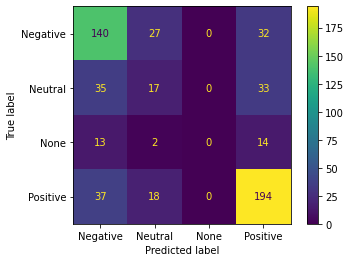

In [87]:
disp.plot()
plt.show()

Does quite poorly predicting Neutral sentiment. Also seems to detect sentiment in a number of reviews where the user gave no rating

In [89]:
sentiment_df

,seat,cabin_staff_service,food,inflight_entertainment,ground_service,wifi
0,nan,Positive,Neutral,nan,nan,nan
1,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan
3,Negative,nan,nan,nan,nan,nan
4,Negative,Positive,Positive,Positive,nan,Positive
...,...,...,...,...,...,...
245,Positive,Positive,Negative,Positive,nan,Negative
246,nan,Negative,nan,nan,nan,nan
247,nan,Positive,Negative,Negative,nan,nan
248,nan,Negative,nan,nan,nan,nan


#### a. Looking at Neutral predictions

In [111]:
#List to store the rows with Neutral predictions
idx_with_neutral = []

#Iter
for index,row in sentiment_df.iterrows():
    
    for var in row:
        
        if var == 'Neutral':
            
            idx_with_neutral.append(index)
            break
        

[0]


[0]




In [ ]:


#Print the text, the aspects and the models prediction for the aspects
for idx,value in enumerate(_):
    
    print('Text', idx+1,':')
    print(original_df.iloc[value,2], '\n')
    
    print('\n','Model aspect predictions')
    for attr, pred in zip(sentiment_df.iloc[idx].index,sentiment_df.iloc[idx].values):
        print('- ',attr,': ',pred)
        
    print('\n') 

In [34]:
_[:10]

array([ 764,  613,  574, 1166,  380,  634,  911, 1081,  994,  730])

## 5. Model Discussion
Reviewing the efficacy of the model above for the review aspect prediction

In [114]:
senti = nlp(airlines_df.review_text[0],aspects = ['food'])

In [119]:
senti

CompletedTask(text='ive flown ethiopian airlines couple times generally satisfied best better many recently flew add iad horrible flight  flight attendant serving water cabin nice since confiscated water bottles boarding seated back cabin ran water never came back cares  food beverage service absolutely slowest ive ever seen life  transatlantic flights would work hard go slower two flight attendants serving  two standing around absolutely nothing never see lazier group flight attendants life  food worse bad  inedible beef nothing grizzle fat  wouldnt serve dog plan organization service  none terrible flight among worst flights ive cabin crew lazy beyond words avoid airline possible', aspects=['food'], subtasks=OrderedDict([('food', CompletedSubTask(text='ive flown ethiopian airlines couple times generally satisfied best better many recently flew add iad horrible flight  flight attendant serving water cabin nice since confiscated water bottles boarding seated back cabin ran water never 

In [ ]:
0.0022452353, 0.9880703, 0.009684446

In [126]:
0.011+0.988+0.001

1.0

In [127]:
_ , k, d = reviews_absa(airlines_df,7)

In [128]:
k

,seat,cabin_staff_service,food,inflight_entertainment,ground_service,wifi
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Negative,Positive,Positive,NaN,NaN
2,NaN,Negative,NaN,NaN,NaN,NaN
3,Negative,Positive,Negative,Negative,NaN,Positive
4,Neutral,Negative,NaN,Negative,NaN,NaN
5,NaN,Positive,Negative,Negative,NaN,Positive
6,Neutral,Positive,Positive,NaN,NaN,NaN


In [129]:
d

,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity
835,Negative,Negative,Negative,NaN,Negative,NaN
1015,Positive,Positive,Positive,Positive,Positive,NaN
785,Negative,Negative,NaN,NaN,Negative,NaN
205,Negative,Positive,Negative,Negative,Negative,Negative
257,Neutral,Neutral,Negative,Negative,Negative,NaN
1143,Positive,Positive,Negative,Positive,Neutral,Negative
369,Positive,Positive,Neutral,Neutral,Neutral,NaN
